## Imports

In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import polars as pl
import pyarrow
from scipy.signal import savgol_filter

## Data Loading & Pre-processing

In [5]:
# Save the initial directory
initial_directory = os.getcwd()


In [6]:
# Load the CSV files into DataFrames
os.chdir(initial_directory)
os.chdir('..')
df = pl.read_csv('Data/bills.csv')
venues_df = pl.read_csv('Data/venues.csv')

# Merge the DataFrames on the 'venue_xref_id' column
df = df.join(venues_df, on='venue_xref_id', how='left')

# Display the first few rows of the DataFrame
df.head()


bill_paid_at_local,bill_total_billed,bill_total_discount_item_level,bill_total_gratuity,bill_total_net,bill_total_tax,bill_total_voided,bill_uuid,business_date,order_duration_seconds,order_seated_at_local,order_closed_at_local,order_take_out_type_label,order_uuid,payment_amount,payment_count,payment_total_tip,sales_revenue_with_tax,venue_xref_id,waiter_uuid,concept,city,country,start_of_day_offset
str,f64,f64,f64,f64,f64,f64,str,str,i64,str,str,str,str,f64,i64,f64,f64,str,str,str,str,str,str
"""2024-07-01 09:17:01""",21.81,0.0,0.0,19.3,2.51,0.0,"""240701091701~4D63608F-523C-4EF…","""2024-07-01""",46,"""2024-07-01 09:16:15""","""2024-07-01 09:17:01""","""dinein""","""240701091615~EF1C6E91-B6C4-4DF…",21.81,1,0.0,21.81,"""39e5b4830d4d9c14db7368a95b65d5…","""161027134744~719D0E09-5CA7-442…",null,"""Collingwood""","""CA""","""00:00:00"""
"""2024-07-01 13:37:00""",48.95,0.0,0.0,43.32,5.63,0.0,"""240701133659~3A0BEDE2-E9E5-484…","""2024-07-01""",288,"""2024-07-01 13:32:12""","""2024-07-01 13:37:00""","""dinein""","""240701133212~A4C33BFA-A54F-462…",48.95,1,0.0,48.95,"""39e5b4830d4d9c14db7368a95b65d5…","""161027134744~719D0E09-5CA7-442…",null,"""Collingwood""","""CA""","""00:00:00"""
"""2024-07-01 11:19:32""",26.94,0.0,0.0,23.84,3.1,0.0,"""240701111931~670EEB85-E939-492…","""2024-07-01""",135,"""2024-07-01 11:17:17""","""2024-07-01 11:19:32""","""dinein""","""240701111717~6074B0AB-2432-484…",26.94,1,0.0,26.94,"""39e5b4830d4d9c14db7368a95b65d5…","""161027134744~719D0E09-5CA7-442…",null,"""Collingwood""","""CA""","""00:00:00"""
"""2024-07-01 15:05:59""",3.96,0.0,0.0,3.77,0.19,0.0,"""240701150558~3D6F473E-D5EF-4BB…","""2024-07-01""",48,"""2024-07-01 15:05:11""","""2024-07-01 15:05:59""","""dinein""","""240701150511~EAA68F41-20ED-4FC…",3.96,1,0.0,3.96,"""39e5b4830d4d9c14db7368a95b65d5…","""161027134744~719D0E09-5CA7-442…",null,"""Collingwood""","""CA""","""00:00:00"""
"""2024-07-01 12:41:00""",3.36,0.0,0.0,3.2,0.16,0.0,"""240701124059~0521794C-51FC-4C3…","""2024-07-01""",103,"""2024-07-01 12:39:17""","""2024-07-01 12:41:00""","""dinein""","""240701123917~27764E1C-7E7F-429…",3.36,1,0.0,3.36,"""39e5b4830d4d9c14db7368a95b65d5…","""161027134744~719D0E09-5CA7-442…",null,"""Collingwood""","""CA""","""00:00:00"""


## Data Cleansing

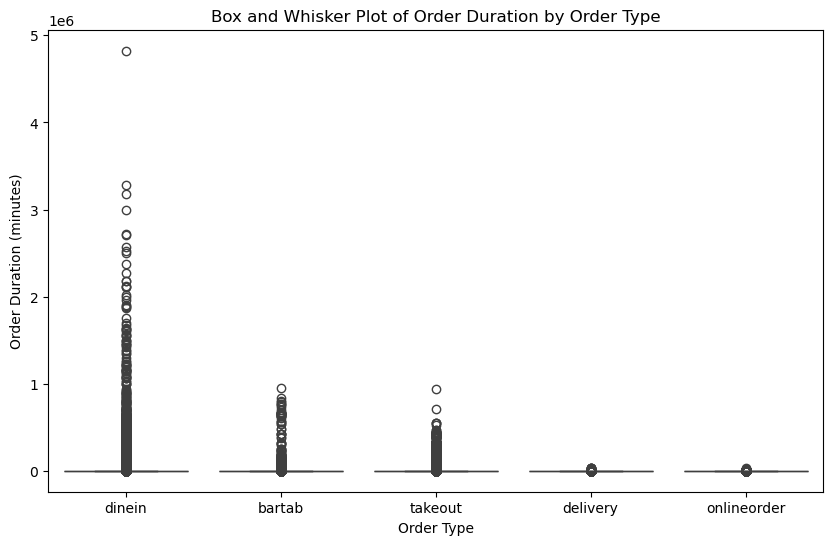

In [38]:
# Convert order duration from seconds to minutes
df = df.with_columns((df["order_duration_seconds"] / 60).alias("order_duration_minutes"))

# Convert relevant columns to NumPy arrays for Seaborn
x_values = df["order_take_out_type_label"].to_numpy()
y_values = df["order_duration_minutes"].to_numpy()

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=x_values, y=y_values)
plt.title("Box and Whisker Plot of Order Duration by Order Type")
plt.xlabel("Order Type")
plt.ylabel("Order Duration (minutes)")
plt.show()

In [41]:
# Function to find the non-linear point in the quantile curve
def find_sensitive_threshold(df, order_type = "dinein", column_name='order_duration_minutes', 
                            quantile_min=0.935, quantile_max=0.985, quantile_step=0.001,
                            window_length=7, polyorder=2, 
                            method='second_derivative', plot_results=True):
    """
    Finds threshold using more sensitive methods to detect earlier curve changes.
    
    Parameters:
    -----------
    df : polars.DataFrame
        DataFrame containing the data
    column_name : str
        Name of the column to analyze
    quantile_min, quantile_max : float
        Range of quantiles to analyze
    quantile_step : float
        Step size between quantiles
    window_length : int
        Window length for Savitzky-Golay filter (must be odd)
    polyorder : int
        Polynomial order for Savitzky-Golay filter
    method : str
        Detection method: 'second_derivative', 'percentage_change', 'moving_average'
    plot_results : bool
        Whether to plot results of the analysis
    
    Returns:
    --------
    dict
        Dictionary containing the results
    """
    # Filter the DataFrame for the specific order type
    type_df = df.filter(pl.col("order_take_out_type_label") == order_type)

    # Calculate quantiles
    quantiles = np.arange(quantile_min, quantile_max, quantile_step)
    quantile_values = [df.select(pl.col(column_name).quantile(q)).item() for q in quantiles]
    
    # Calculate slopes
    slopes = np.diff(quantile_values) / np.diff(quantiles)
    
    # Apply Savitzky-Golay filter to smooth the slopes
    smooth_slopes = savgol_filter(slopes, window_length=window_length, polyorder=polyorder)
    
    # Various detection methods
    if method == 'second_derivative':
        # Calculate the second derivative to find acceleration in the slope
        second_derivatives = np.diff(smooth_slopes)
        
        # Smooth the second derivatives
        smooth_second_derivatives = savgol_filter(second_derivatives, 
                                                 window_length=min(window_length, len(second_derivatives) - 2), 
                                                 polyorder=min(polyorder, 1))
        
        # Find where the second derivative starts increasing significantly
        # First, normalize the second derivatives
        normalized_second_derivatives = smooth_second_derivatives / np.max(np.abs(smooth_second_derivatives))
        
        # Look for the point where the normalized second derivative exceeds a threshold
        # Start from 10% of the way through the data to avoid initial noise
        start_idx = int(len(normalized_second_derivatives) * 0.1)
        threshold = 0.15  # 15% of max second derivative
        
        for i in range(start_idx, len(normalized_second_derivatives)):
            if normalized_second_derivatives[i] > threshold:
                non_linear_index = i + 1  # +1 because of diff operation
                break
        else:
            # Fallback: Find point of maximum second derivative
            non_linear_index = np.argmax(smooth_second_derivatives) + 1
            
    elif method == 'percentage_change':
        # Calculate percentage change between consecutive slope values
        pct_changes = np.diff(smooth_slopes) / smooth_slopes[:-1]
        
        # Find the point where percentage change exceeds threshold
        threshold = 0.03  # 3% change
        try:
            indices = np.where(pct_changes > threshold)[0]
            non_linear_index = indices[0] + 1  # +1 because of diff operation
        except:
            # Fallback
            non_linear_index = len(slopes) // 3  # Early detection
            
    elif method == 'moving_average':
        # Use moving average crossover technique
        window_short = max(3, window_length // 3)
        window_long = window_length
        
        # Calculate short and long moving averages of the slopes
        ma_short = np.convolve(smooth_slopes, np.ones(window_short)/window_short, mode='valid')
        ma_long = np.convolve(smooth_slopes, np.ones(window_long)/window_long, mode='valid')
        
        # Pad the shorter moving average to match lengths
        pad_length = len(ma_long) - len(ma_short)
        ma_short = np.pad(ma_short, (pad_length, 0), 'edge')
        
        # Calculate ratio between short and long MAs
        ma_ratio = ma_short / ma_long
        
        # Find where ratio starts increasing significantly
        threshold = 1.05  # 5% increase
        try:
            indices = np.where(ma_ratio > threshold)[0]
            non_linear_index = indices[0] + window_long - 1
        except:
            # Fallback
            non_linear_index = len(slopes) // 3
            
    else:
        # Default method: Find early significant change
        # Calculate percentage increase compared to baseline
        baseline = np.mean(smooth_slopes[:int(len(smooth_slopes)*0.1)])  # First 10% as baseline
        percent_increase = (smooth_slopes / baseline) - 1
        
        # Find where percent increase exceeds threshold
        threshold = 0.5  # 50% increase from baseline
        try:
            indices = np.where(percent_increase > threshold)[0]
            non_linear_index = indices[0]
        except:
            # Fallback to relative threshold method but with higher sensitivity
            relative_threshold = 0.02  # More sensitive than original 0.05
            try:
                non_linear_index = np.where(np.abs(np.diff(smooth_slopes)) > 
                                          np.abs(smooth_slopes[:-1]) * relative_threshold)[0][0] + 1
            except:
                non_linear_index = len(slopes) // 3
    
    # Ensure non_linear_index is within bounds
    non_linear_index = min(max(0, non_linear_index), len(quantiles) - 2)
    
    # Calculate the quantile and value at the non-linear point
    non_linear_quantile = quantiles[non_linear_index]
    non_linear_value = quantile_values[non_linear_index]
    
    # Calculate the slope from start to non-linear point
    start_to_non_linear_slope = (non_linear_value - quantile_values[0]) / (non_linear_quantile - quantiles[0])
    
    # Calculate effective relative threshold for the chosen point
    try:
        effective_threshold = np.abs(np.diff(smooth_slopes)[non_linear_index-1]) / np.abs(smooth_slopes[non_linear_index-1])
    except:
        effective_threshold = 0
    
    if plot_results:
        # Create a 2x2 grid of plots
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f"Analysis for Order Type: {order_type}", fontsize=16)
        
        # Plot 1: Quantile values
        axes[0, 0].plot(quantiles, quantile_values, marker='o', label='Quantile Values')
        axes[0, 0].axvline(x=quantiles[non_linear_index], color='red', linestyle='--', label=f'Non-linear Point (Quantile: {quantiles[non_linear_index]:.3f})')
        axes[0, 0].set_title("Quantile Values")
        axes[0, 0].set_xlabel("Quantile")
        axes[0, 0].set_ylabel("Order Duration Minutes")
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot 2: Slopes
        axes[0, 1].plot(quantiles[1:], slopes, label='Raw Slopes', alpha=0.6)
        axes[0, 1].plot(quantiles[1:], smooth_slopes, label='Smoothed Slopes', color='orange')
        axes[0, 1].axvline(x=quantiles[non_linear_index], color='red', linestyle='--')
        axes[0, 1].set_title("Slopes Between Quantiles")
        axes[0, 1].set_xlabel("Quantile")
        axes[0, 1].set_ylabel("Slope")
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot 3: Second derivative (if applicable)
        second_derivatives = np.diff(smooth_slopes)
        axes[1, 0].plot(quantiles[2:], second_derivatives, label='Second Derivatives', alpha=0.6)
        axes[1, 0].axvline(x=quantiles[non_linear_index], color='red', linestyle='--')
        axes[1, 0].set_title("Second Derivatives of Slopes")
        axes[1, 0].set_xlabel("Quantile")
        axes[1, 0].set_ylabel("Second Derivative")
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Plot 4: Box and Whisker Plot
        # Filter out orders past the respective quantile and remap to the median order duration
        quantile_threshold = type_df.select(pl.col("order_duration_minutes").quantile(quantiles[non_linear_index])).item()
        median_duration = type_df.select(pl.col("order_duration_minutes").median()).item()
        filtered_type_df = type_df.with_columns(
            pl.when(pl.col("order_duration_minutes") > quantile_threshold)
            .then(median_duration)
            .otherwise(pl.col("order_duration_minutes"))
            .alias("order_duration_minutes")
        )
        
        # Create a box and whisker plot with the filtered data
        sns.boxplot(
            ax=axes[1, 1],
            x=filtered_type_df["order_take_out_type_label"].to_numpy(),
            y=filtered_type_df["order_duration_minutes"].to_numpy()
        )
        axes[1, 1].set_title("Box and Whisker Plot")
        axes[1, 1].set_xlabel("Order Type")
        axes[1, 1].set_ylabel("Order Duration Minutes")
        axes[1, 1].grid(True)
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # Return results and filtered dataset
        return {
            "non_linear_quantile": non_linear_quantile,
            "non_linear_value": non_linear_value,
            "start_to_non_linear_slope": start_to_non_linear_slope,
            "effective_threshold": effective_threshold
        }, filtered_type_df


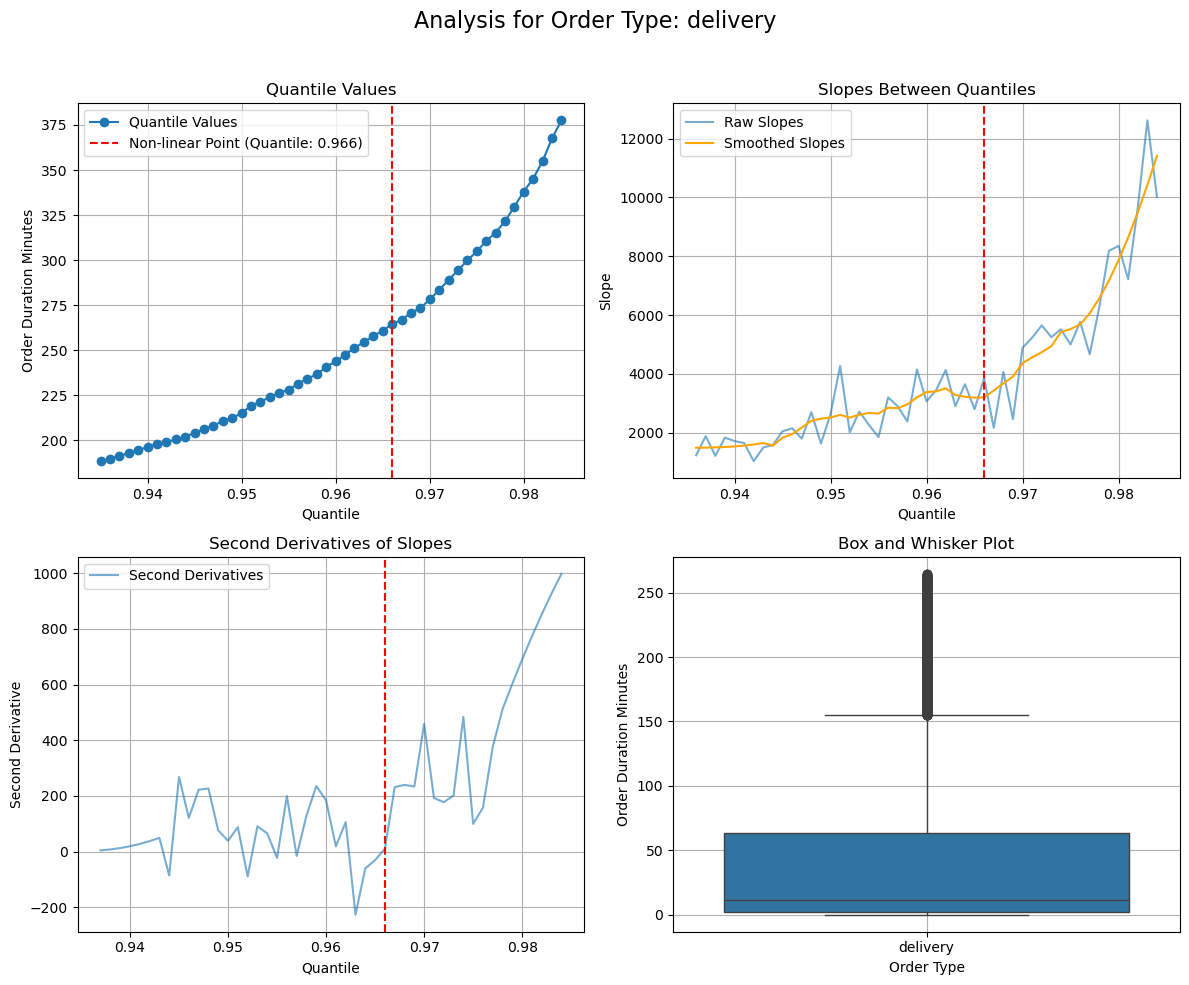

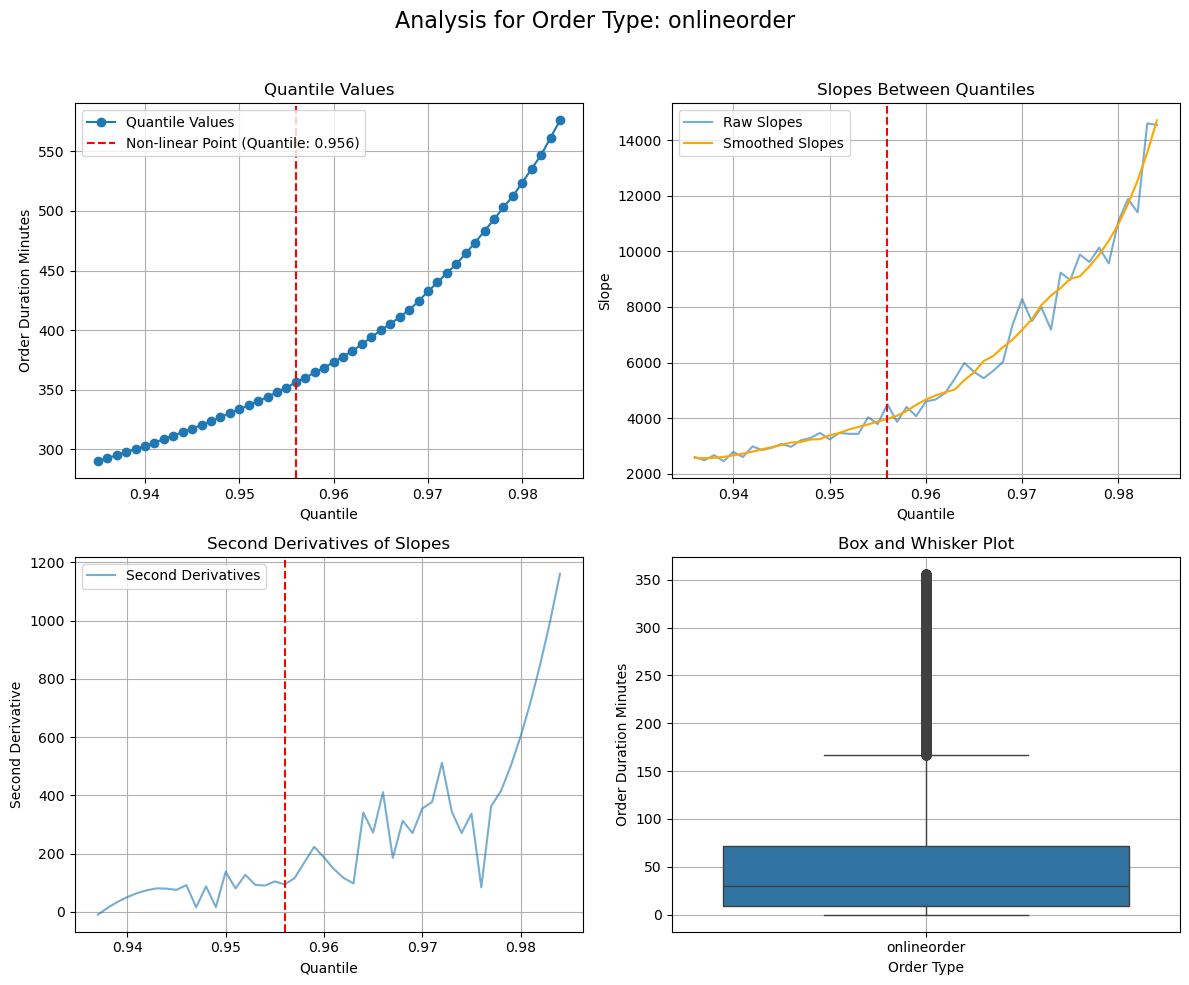

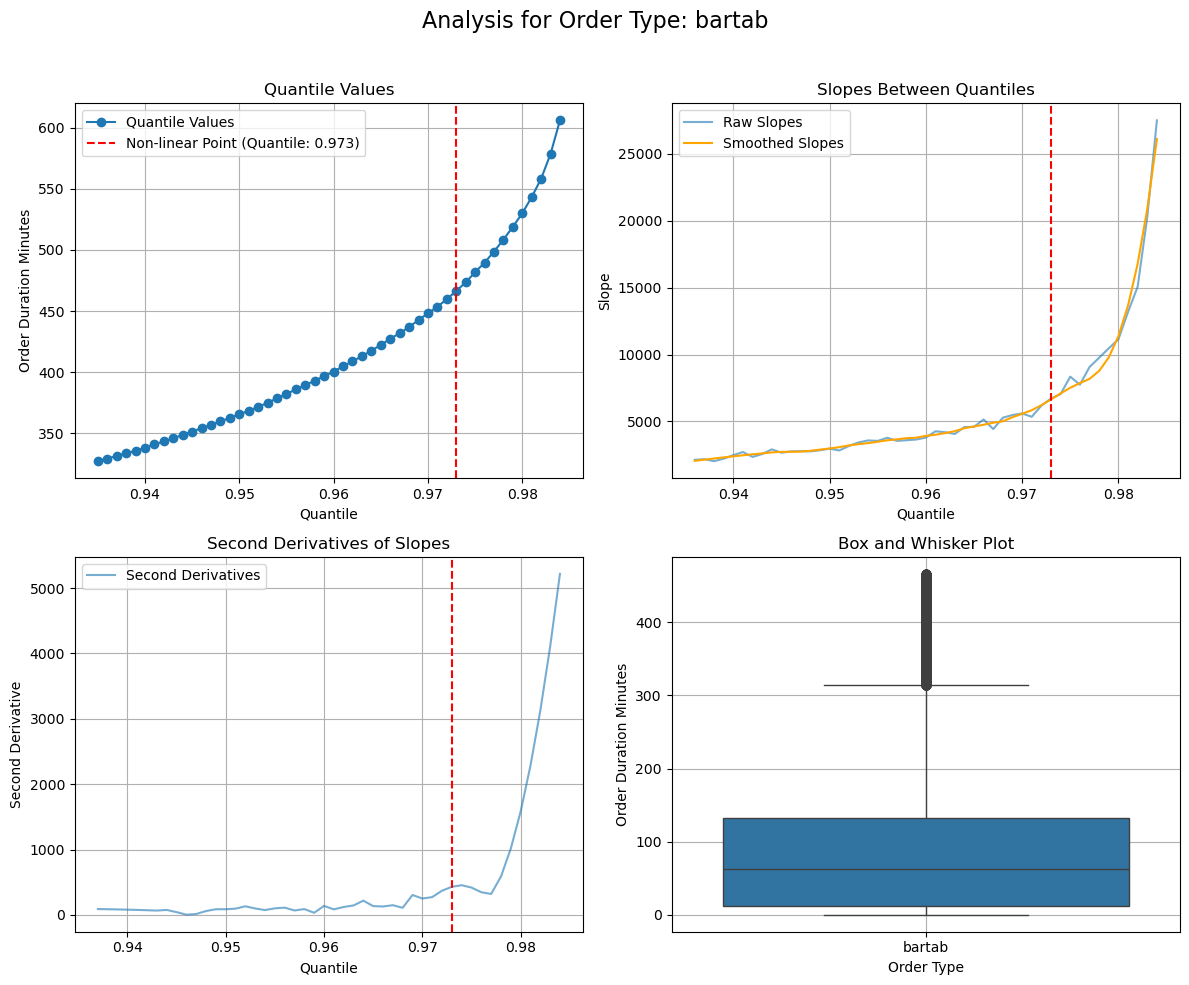

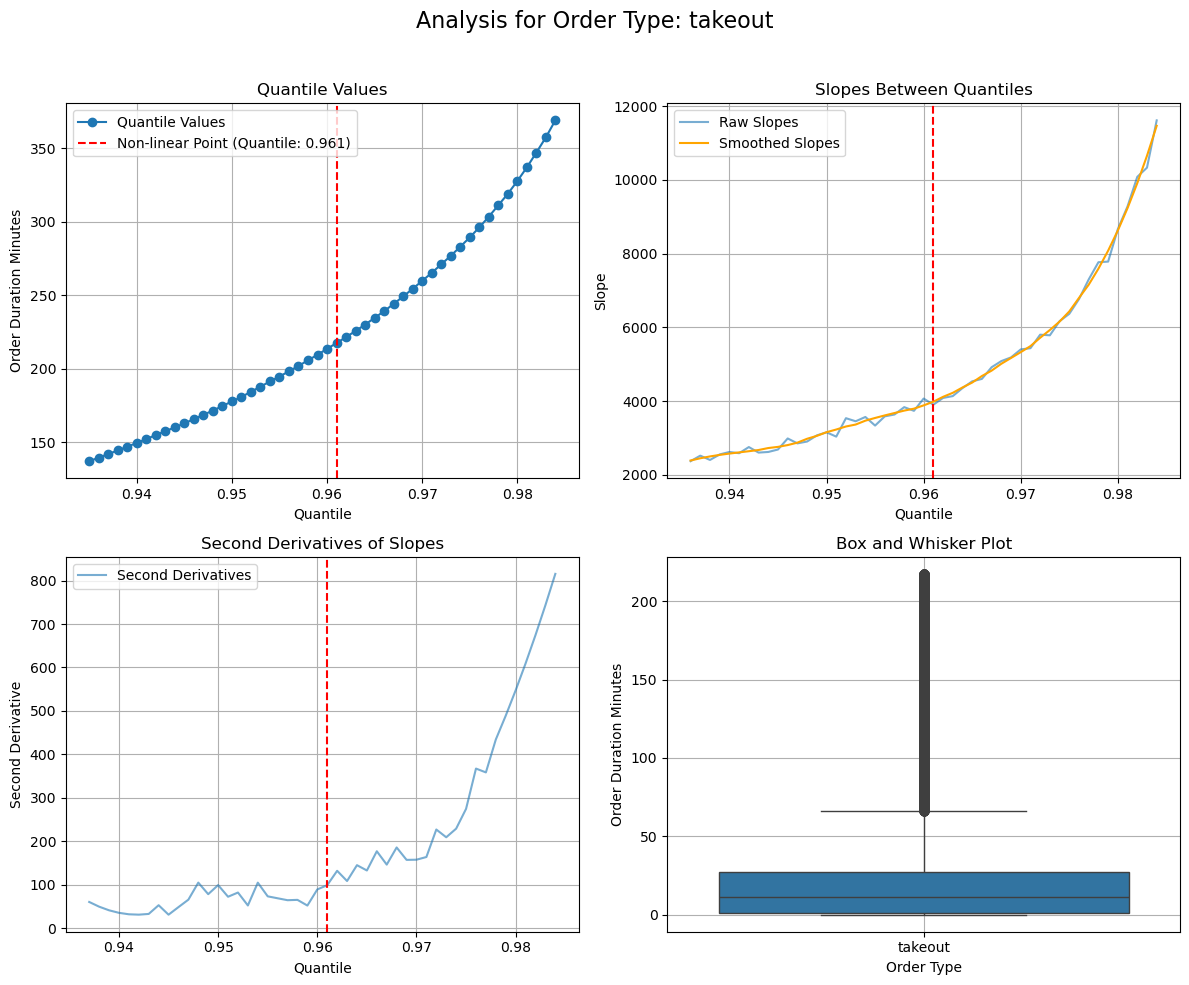

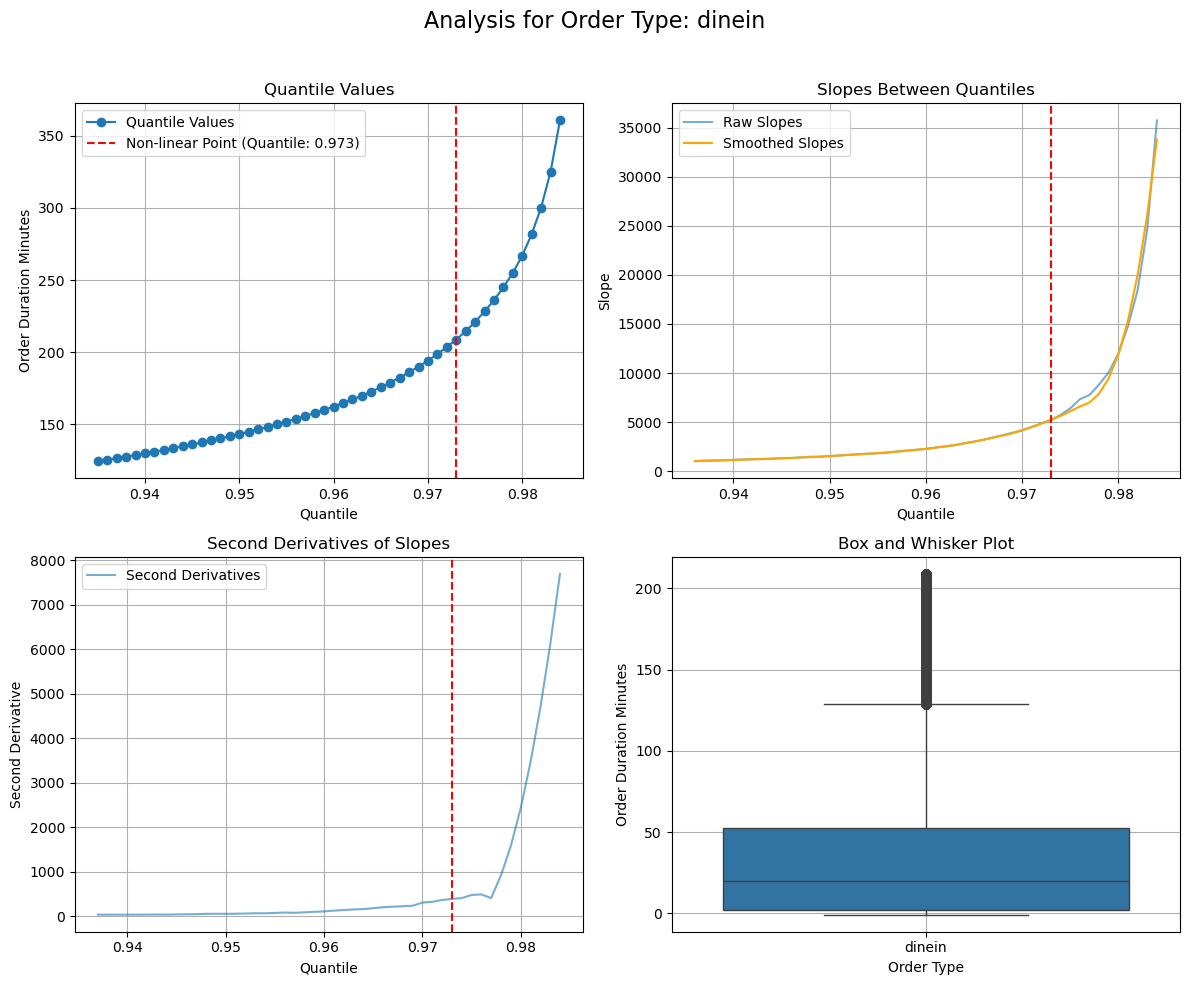

In [42]:
# Group the data by order type and find the threshold for each group
order_types = df["order_take_out_type_label"].unique()
thresholds_per_type = {}
filtered_datasets = []

# Iterate over each order type
for order_type in order_types:
    # Filter the data for the current order type
    type_df = df.filter(pl.col("order_take_out_type_label") == order_type)
    
    # Find the optimal threshold for the current order type
    threshold_result = find_sensitive_threshold(type_df, order_type=order_type, column_name='order_duration_minutes', 
                                                window_length=15, polyorder=3, plot_results=True)
    
    # Check if the function returned a valid result
    if threshold_result is not None:
        result, filtered_df = threshold_result
        # Save the threshold result
        thresholds_per_type[order_type] = result
        # Append the filtered dataset
        filtered_datasets.append(filtered_df)
    else:
        print(f"Warning: No result returned for order type '{order_type}'. Skipping.")
    
    # Save the threshold result
    thresholds_per_type[order_type] = result
    
    # Append the filtered dataset
    filtered_datasets.append(filtered_df)

# Combine all filtered datasets into one
combined_filtered_df = pl.concat(filtered_datasets)

  

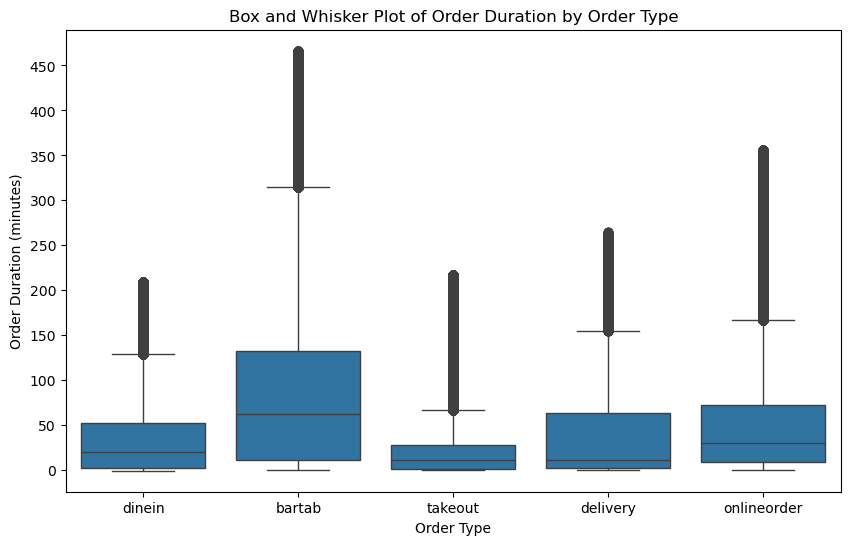

In [48]:
# Create a box and whisker plot
plt.figure(figsize=(10, 6))

# Use Polars native operations to prepare data for boxplot
plot_data = {
    'x': combined_filtered_df.get_column("order_take_out_type_label"),
    'y': combined_filtered_df.get_column("order_duration_minutes")
}

# Create boxplot with specific order
sns.boxplot(x=plot_data['x'], y=plot_data['y'], 
            order=["dinein", "bartab", "takeout", "delivery", "onlineorder"])

plt.title("Box and Whisker Plot of Order Duration by Order Type")
plt.xlabel("Order Type")
plt.ylabel("Order Duration (minutes)")
plt.yticks(range(0, int(combined_filtered_df.get_column("order_duration_minutes").max()) + 1, 50))
plt.show()